### summary overview

####### Using a <a target="_blank" href="https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method">Box Jenkins</a>-style methodology:
<br>
1) plotting to visually assess time series, identify any notable characteristics (stationarity, etc)
<br>
2) parameter estimation:  arrive at coefficients that best fit AR/ARIMA models
<br>
3) evaluate: check whether models conform to the specifications of a stationary univariate process
<br><br>
** this notebook focuses on part 1

In [1]:
# general import environment
print('versions')
print ('------------')
import pandas as pd
print('pandas: ', pd.__version__)
pd.set_option('display.max_columns', None)

import numpy as np
print('numpy: ', np.__version__)

import time as time
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt
print('mpl: ', mpl.__version__)
%matplotlib inline

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore") # ignore warnings

versions
------------
pandas:  0.20.3
numpy:  1.13.3
mpl:  2.0.2


### load cached data

In [2]:
#### cache during development
temporal_group = 'weekly'
df = pd.read_csv('data/historical_data_{0}.csv'.format(temporal_group))

In [3]:
# force convert string dates to dt objects
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

### visual spot check data

In [4]:
# set some plotting params
# =-=--=-=-=-==-=-=-=-=-=--==-=
circ_radius = 150
circ_alpha = 0.08
color_list = ['purple','green','#295673','blue','orange','black']
column_list = ['DGS1MO','DGS5','DGS30']

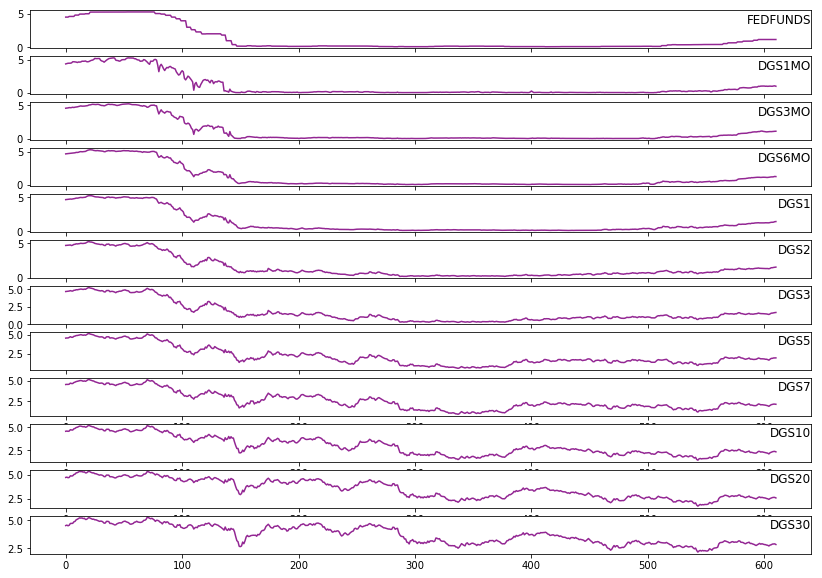

In [5]:
# plt all 7 variables as subplots
mpl.rc('figure', figsize=(14, 10))
values = df.values
# specify columns to plot
groups = list(np.arange(len(df.columns.values)))
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group],color='purple',alpha=0.85)
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [6]:
# df[column_list[-1]].plot(c=color_list[0])
# df[column_list[0]].plot(c=color_list[1])

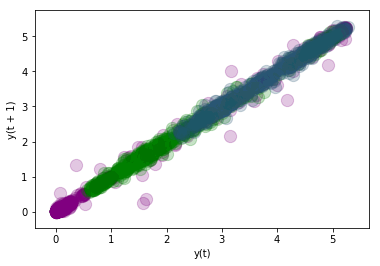

In [7]:
# spot check pd lag plots --- default ==> lag=1
# linear relationships indicate more autoregressive predictability
# =-=--=-=-=-==-=-=-=-=-=--==-=
mpl.rc('figure', figsize=(6, 4))
lag_n = 1
for iter_x in np.arange(3):
    pd.plotting.lag_plot(pd.Series(list(df[column_list[iter_x]].values)),\
                         lag=lag_n,c=color_list[iter_x],s=circ_radius,alpha=circ_alpha)
    pd.plotting.lag_plot(pd.Series(list(df[column_list[iter_x]].values)),\
                         lag=lag_n,c=color_list[iter_x],s=circ_radius,alpha=circ_alpha)
    pd.plotting.lag_plot(pd.Series(list(df[column_list[iter_x]].values)),\
                         lag=lag_n,c=color_list[iter_x],s=circ_radius,alpha=circ_alpha)
plt.show;

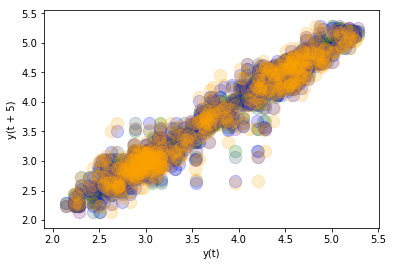

In [8]:
# spot checking longer lags [single column] | linearity decays
col_x = column_list[-1]
lag_n = 5

circ_alpha = 0.2
for iter_x in np.arange(lag_n):
    pd.plotting.lag_plot(pd.Series(list(df[col_x].values)),lag=(iter_x+1),\
                         c=color_list[iter_x],s=circ_radius,alpha=circ_alpha)

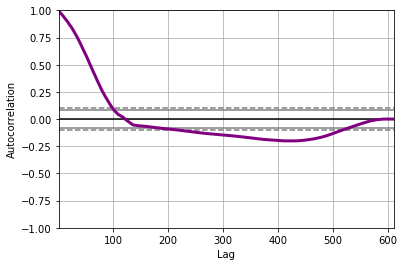

In [9]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(df['DGS1MO'],c='purple',lw=3)

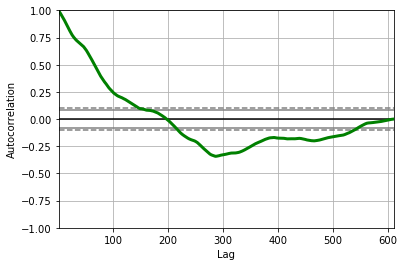

In [10]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(df['DGS5'],c='green',lw=3)

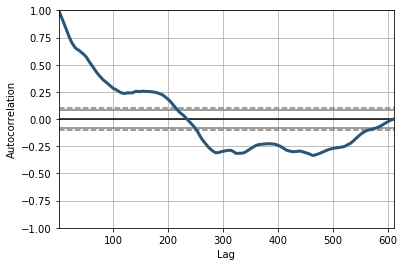

In [11]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(df['DGS30'],c='#295673',lw=3)

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

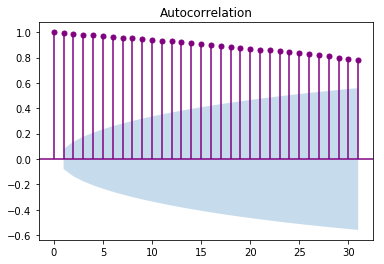

In [13]:
plot_acf(df['DGS1MO'], lags=31,color='purple')
plt.show()

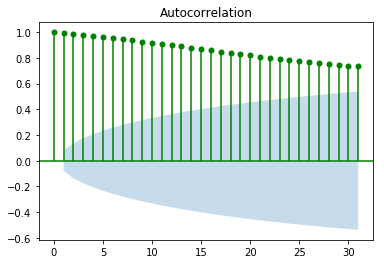

In [14]:
plot_acf(df['DGS5'], lags=31,color='green')
plt.show()

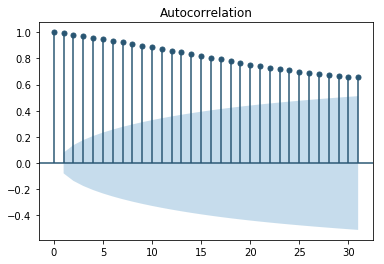

In [15]:
plot_acf(df['DGS30'], lags=31,color='#295673')
plt.show()

In [16]:
# set target column
timeseries = df['DGS30'].values

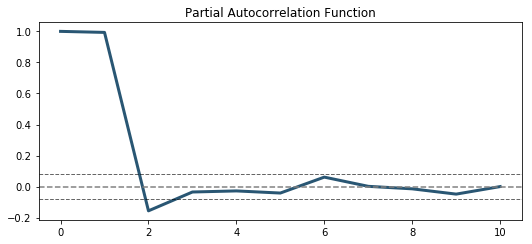

In [17]:
lag_num = 10
from statsmodels.tsa.stattools import acf, pacf

conf_int_marks = 1.96
# lag_acf = acf(timeseries, nlags=lag_num)
lag_pacf = pacf(timeseries, nlags=lag_num, method='ols')

mpl.rc('figure', figsize=(7.5, 3.5))

#Plot PACF:
# plt.subplot(122)
plt.plot(lag_pacf,c=color_list[2],lw=3)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-conf_int_marks/np.sqrt(len(timeseries)),linestyle='--',color='k',lw=1,alpha=0.6)
plt.axhline(y=conf_int_marks/np.sqrt(len(timeseries)),linestyle='--',color='k',lw=1,alpha=0.6)
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

###### time series decomposition

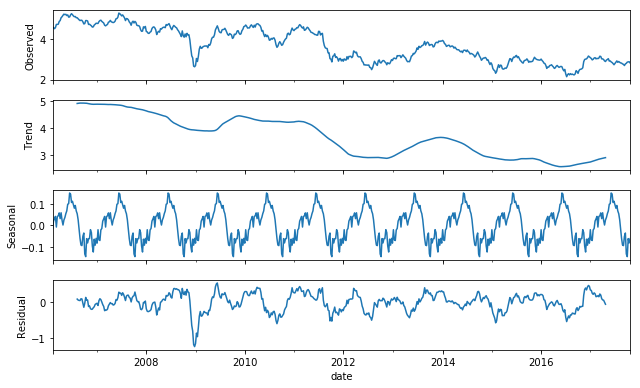

In [18]:
import statsmodels.api as sm
mpl.rc('figure', figsize=(9, 5.5))
sdecomp = pd.DataFrame()
sdecomp['DGS30'] = df['DGS30']
res = sm.tsa.seasonal_decompose(sdecomp)
resplot = res.plot()

In [19]:
# select single columns, create n-lagged variables, plot correlation matrix
lag_num = 20
corr_df = pd.DataFrame()
corr_df['DGS30'] = df['DGS30']
for shift_n in np.arange(lag_num):
    corr_df['DGS30_{0}'.format(shift_n)] = corr_df['DGS30'].shift(shift_n)

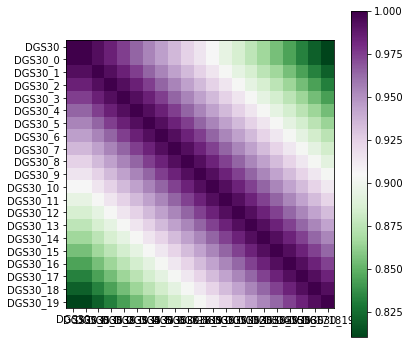

In [20]:
# closer lags are uniformly more highly correlated
corr = corr_df.corr()
mpl.rc('figure', figsize=(6, 6))
# plt.imshow(corr, cmap=plt.cm.YlOrRd, interpolation='none')
plt.imshow(corr, cmap=plt.cm.PRGn_r, interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

In [21]:
# Dickey-Fuller test (check for stationarity) | FAILS
from statsmodels.tsa.stattools import adfuller

In [22]:
# select time series to check
timeseries = df['DGS30'].values
rolling_window = 4
rolmean = pd.Series(timeseries).rolling(window=rolling_window).mean().dropna()
rolstd = pd.Series(timeseries).rolling(window=rolling_window).std().dropna()

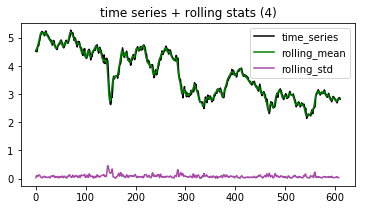

In [23]:
#Plot rolling statistics:
mpl.rc('figure', figsize=(6, 3))
orig = plt.plot(timeseries, color='black',label='time_series')
mean = plt.plot(rolmean.values, color='green', label='rolling_mean')
std = plt.plot(rolstd.values, color='purple', label = 'rolling_std',alpha=0.7)
plt.legend(loc='best')
plt.title('time series + rolling stats ({0})'.format(rolling_window))
plt.show(block=False)

In [24]:
print('dickey-fuller test:')
print('=-=--==--=-=-=-==-=')
dickey_fuller_results = adfuller(timeseries, autolag='AIC')  #returns tuple
dfoutput = pd.Series(dickey_fuller_results[0:4], index=['test_stat','p_val','lag_num','n_obs']) #[0:4] excludes 1,5,10% critical vals
for key,value in dickey_fuller_results[4].items():
    dfoutput['crit vals ({0})'.format(key)] = value
print(dfoutput)

dickey-fuller test:
=-=--==--=-=-=-==-=
test_stat           -1.668551
p_val                0.447385
lag_num              1.000000
n_obs              609.000000
crit vals (1%)      -3.441133
crit vals (5%)      -2.866298
crit vals (10%)     -2.569304
dtype: float64


### Summary assessment